<a href="https://colab.research.google.com/github/kskaran94/CNN-TransferLearning/blob/master/CNN_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following script has been written in Google colab notebook. 
The data set is available on kaggle. The aim of the script is not to get a perfect score on Kaggle leaderboard but to understand Convolution Neural Networks and Transfer learning.  I have used only the train dataset here. 


## **Libraries Imported**

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
from glob import glob
import fnmatch
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, \
Dense, Dropout, Input, add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import shutil
import warnings
warnings.filterwarnings('ignore')


In [2]:
uploaded = files.upload()


## **Reading Data**

Downloading data from kaggle . If you have this data available , then you can skip this code cell

In [3]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

token = {"username":"kskaran94","key":"67ffe4a038a3668b565ca33b1a78dd01"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
! chmod 600 /root/.kaggle/kaggle.json

! kaggle competitions download -c aerial-cactus-identification

cp: cannot stat 'kaggle.json': No such file or directory
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 44.0MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 49.4MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.0MB/s]
 47% 9.00M/19.2M [00:00<00:00, 64.5MB/s]
100% 19.2M/19.2M [00:00<00:00, 94.0MB/s]


In [0]:
! unzip /content/train.zip
! unzip /content/test.zip

Read the target csv, which contains image url and the label. This csv will help us reorganize the data.

In [5]:
target_csv = pd.read_csv('/content/train.csv')
target_csv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


Re-arranging the data and moving it into a target based folder structure

In [0]:

!mkdir /content/data/
!mkdir /content/data/0/
!mkdir /content/data/1/


urls_1 = target_csv[target_csv['has_cactus']==1]['id'].values
urls_0 = target_csv[target_csv['has_cactus']==0]['id'].values



for file in urls_0:
    shutil.copy('/content/train/'+ file, '/content/data/0/')

for file in urls_1:
    shutil.copy('/content/train/'+ file, '/content/data/1/')

## **Data Transformation**

Reading a sub sample of class 0 images and re -sizing them with height and width=50. The images are read in X and the labels in Y. The same process is repeated for class 1 images.

All the images have to be of the same size , hence the resizing is necessary.

In [0]:
x = []
y = []
WIDTH = 50
HEIGHT = 50

for img in urls_0:
    full_size_image = cv2.imread('/content/data/0/'+img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(0)
    
for img in urls_1:
    full_size_image = cv2.imread('/content/data/1/'+img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(1)

Preprocessing of images: Dividing image by 255 for standarization. We could also transform the images from RGB to gray scale.

Dividing the images into train and test with stratified sampling. So the distribution across train and test remain the same

## **Train-test split**

In [8]:
X=np.array(x)
X = X/255

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify = y)



print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (14000, 50, 50, 3)
Testing Data Shape: (3500, 50, 50, 3)


## **Base Model**

Defining the neural network: For simplicity of the problem I have kept 2 convolution layers with kernel_size (3,3), followed by batch normalization ,Max pooling of (2,2) and Dropout.

The drop out parameter , Max pool size can be tuned but due to restriction of computational resources , I was unable to. The same can be said for kernel size.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 12600 samples, validate on 1400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 5s - loss: 0.4445 - acc: 0.8656 - val_loss: 1.7743 - val_acc: 0.2443
Epoch 2/30
 - 1s - loss: 0.1825 - acc: 0.9379 - val_loss: 2.1664 - val_acc: 0.2443
Epoch 3/30
 - 1s - loss: 0.1458 - acc: 0.9507 - val_loss: 1.6743 - val_acc: 0.2500
Epoch 4/30
 - 1s - loss: 0.1349 - acc: 0.9519 - val_loss: 1.3172 - val_acc: 0.3693
Epoch 5/30
 - 1s - loss: 0.1322 - acc: 0.9536 - val_loss: 0.6259 - val_acc: 0.6971
Epoch 6/30
 - 1s - loss: 0.1204 - acc: 0.9572 - val_loss: 0.3167 - val_acc: 0.8529
Epoch 7/30
 - 1s - loss: 0.1140 - acc: 0.9579 - val_loss: 0.2489 - val_acc: 0.8900
Epoch 8/30
 - 1s - loss: 0.1144 - acc: 0.9570 - val_loss: 0.1177 - val_acc: 0.9579
Epoch 9/30
 - 1s - loss: 0.1071 - acc: 0.9606 - val_

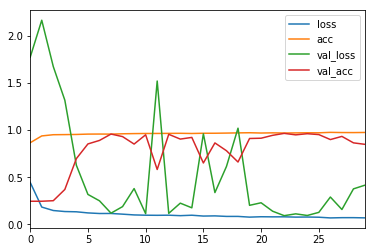

In [9]:
num_classes = 2
input_shape = (50, 50, 3)


cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

cnn_small_bn.compile("adam", "binary_crossentropy", metrics=['accuracy'])
history_cnn = cnn_small_bn.fit(X_train, y_train,
                      batch_size=128, epochs=30, verbose=2, validation_split=.1)
pd.DataFrame(history_cnn.history).plot()

The model performs well on both the train and validation tests.

In [10]:
roc_auc_score(Y_test, cnn_small_bn.predict_classes(X_test))

0.905213330071759

## **Data Segregation**

In [0]:
!mkdir /content/data2/
!mkdir /content/data2/train/
!mkdir /content/data2/test/
!mkdir /content/data2/train/0/
!mkdir /content/data2/train/1/
!mkdir /content/data2/test/0/
!mkdir /content/data2/test/1/


num_rows = target_csv.shape[0]




urls_1 = target_csv[target_csv['has_cactus']==1]['id'].values
urls_0 = target_csv[target_csv['has_cactus']==0]['id'].values

train_rows_1 = int(len(urls_1) * 0.8 )
test_rows_1 = int(len(urls_1) * 0.2 )
train_rows_0 = int(len(urls_0) * 0.8 )
test_rows_0 = int(len(urls_0) * 0.2 )



for file in urls_0[:train_rows_0]:
    shutil.copy('/content/train/'+ file, '/content/data2/train/0/')

for file in urls_1[:train_rows_1]:
    shutil.copy('/content/train/'+ file, '/content/data2/train/1/')
    
    
for file in urls_0[:test_rows_0]:
    shutil.copy('/content/train/'+ file, '/content/data2/test/0/')

for file in urls_1[:test_rows_1]:
    shutil.copy('/content/train/'+ file, '/content/data2/test/1/')

## **Image Augmentation with base model**

Found 13999 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Epoch 1/30
110/110 [==============================] - 4s 37ms/step - loss: 0.1170 - acc: 0.9577
Epoch 2/30
110/110 [==============================] - 4s 37ms/step - loss: 0.0974 - acc: 0.9625
Epoch 3/30
110/110 [==============================] - 4s 37ms/step - loss: 0.0902 - acc: 0.9662
Epoch 4/30
110/110 [==============================] - 4s 36ms/step - loss: 0.0883 - acc: 0.9656
Epoch 5/30
110/110 [==============================] - 4s 36ms/step - loss: 0.0887 - acc: 0.9661
Epoch 6/30
110/110 [==============================] - 4s 36ms/step - loss: 0.0833 - acc: 0.9662
Epoch 7/30
110/110 [==============================] - 4s 35ms/step - loss: 0.0802 - acc: 0.9699
Epoch 8/30
110/110 [==============================] - 4s 35ms/step - loss: 0.0818 - acc: 0.9701
Epoch 9/30
110/110 [==============================] - 4s 36ms/step - loss: 0.0789 - acc: 0.9694
Epoch 10/30
110/110 [==============================

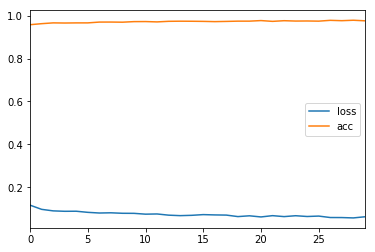

In [12]:
batch_size=128

train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/data2/train/',  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 50x50
        batch_size=batch_size,
        class_mode='categorical', shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        '/content/data2/test/',
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical',         shuffle=True)


history_cnn = cnn_small_bn.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        verbose=1)

pd.DataFrame(history_cnn.history).plot()

In [16]:
test_generator.reset()

pred = cnn_small_bn.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = -1)
classes = test_generator.classes[test_generator.index_array]

roc_auc_score(classes, predicted_class_indices)

0.8955057832739058

Found 13999 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Epoch 1/30
110/110 [==============================] - 13s 119ms/step - loss: 0.0901 - acc: 0.9649
Epoch 2/30
110/110 [==============================] - 13s 118ms/step - loss: 0.0895 - acc: 0.9648
Epoch 3/30
110/110 [==============================] - 13s 119ms/step - loss: 0.0904 - acc: 0.9656
Epoch 4/30
110/110 [==============================] - 13s 119ms/step - loss: 0.0916 - acc: 0.9669
Epoch 5/30
110/110 [==============================] - 13s 119ms/step - loss: 0.0885 - acc: 0.9671
Epoch 6/30
110/110 [==============================] - 13s 120ms/step - loss: 0.0894 - acc: 0.9644
Epoch 7/30
110/110 [==============================] - 13s 121ms/step - loss: 0.0853 - acc: 0.9683
Epoch 8/30
110/110 [==============================] - 13s 120ms/step - loss: 0.0884 - acc: 0.9656
Epoch 9/30
110/110 [==============================] - 13s 119ms/step - loss: 0.0877 - acc: 0.9671
Epoch 10/30
110/110 [============

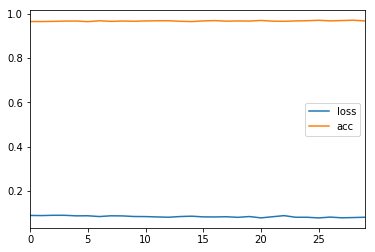

In [17]:
batch_size=128



train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        rotation_range=50,
        height_shift_range=0.1)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/data2/train/',  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 50x50
        batch_size=batch_size,
        class_mode='categorical', shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        '/content/data2/test/',
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical',         shuffle=True)


history_cnn = cnn_small_bn.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        verbose=1)

pd.DataFrame(history_cnn.history).plot()

In [18]:
#test_generator.reset()

pred = cnn_small_bn.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = -1)
classes = test_generator.classes[test_generator.index_array]

roc_auc_score(classes, predicted_class_indices)

0.894175866006852

## **Transfer Learning using Resnet**

In [19]:
num_classes = 2
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

94658560/94653016 [==============================] - 1s 0us/step


Found 13999 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Epoch 1/10
438/438 [==============================] - 15s 34ms/step - loss: 0.1449 - acc: 0.9457
Epoch 2/10
438/438 [==============================] - 13s 30ms/step - loss: 0.0892 - acc: 0.9681
Epoch 3/10
438/438 [==============================] - 13s 31ms/step - loss: 0.0792 - acc: 0.9722
Epoch 4/10
438/438 [==============================] - 13s 31ms/step - loss: 0.0731 - acc: 0.9739
Epoch 5/10
438/438 [==============================] - 13s 31ms/step - loss: 0.0775 - acc: 0.9722
Epoch 6/10
438/438 [==============================] - 13s 30ms/step - loss: 0.0731 - acc: 0.9754
Epoch 7/10
438/438 [==============================] - 13s 30ms/step - loss: 0.0754 - acc: 0.9759
Epoch 8/10
438/438 [==============================] - 13s 30ms/step - loss: 0.0745 - acc: 0.9736
Epoch 9/10
438/438 [==============================] - 13s 30ms/step - loss: 0.0678 - acc: 0.9768
Epoch 10/10
438/438 [=====================

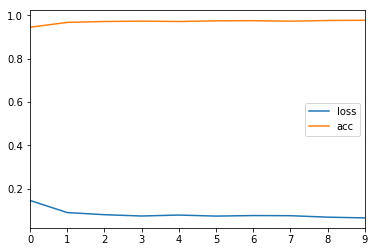

In [20]:
BATCH_SIZE = 32
HEIGHT = 50
WIDTH = 50

train_datagen =  ImageDataGenerator(
          rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory('/content/data2/train/', 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

test_generator = train_datagen.flow_from_directory('/content/data2/test/', 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


num_train_images= 13999
history = model.fit_generator(train_generator, epochs=10, workers=8, 
                              steps_per_epoch=num_train_images // BATCH_SIZE,
                                       shuffle=True)
pd.DataFrame(history.history).plot()

In [23]:
pred = model.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = -1)
classes = test_generator.classes[test_generator.index_array]

roc_auc_score(classes, predicted_class_indices)

0.9488159741987756

Found 13999 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Epoch 1/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1304 - acc: 0.9594
Epoch 2/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1315 - acc: 0.9607
Epoch 3/10
438/438 [==============================] - 23s 53ms/step - loss: 0.1132 - acc: 0.9627
Epoch 4/10
438/438 [==============================] - 23s 53ms/step - loss: 0.1230 - acc: 0.9602
Epoch 5/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1217 - acc: 0.9594
Epoch 6/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1219 - acc: 0.9604
Epoch 7/10
438/438 [==============================] - 23s 53ms/step - loss: 0.1221 - acc: 0.9601
Epoch 8/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1240 - acc: 0.9593
Epoch 9/10
438/438 [==============================] - 23s 52ms/step - loss: 0.1240 - acc: 0.9601
Epoch 10/10
438/438 [=====================

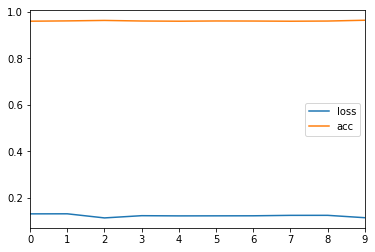

In [24]:


BATCH_SIZE = 32
HEIGHT = 50
WIDTH = 50


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        rotation_range=50,
        height_shift_range=0.1)

test_datagen =  ImageDataGenerator(
          rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory('/content/data2/train/', 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory('/content/data2/test/', 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


num_train_images= 13999
history = model.fit_generator(train_generator, epochs=10, workers=8, 
                              steps_per_epoch=num_train_images // BATCH_SIZE,
                                       shuffle=True)
pd.DataFrame(history.history).plot()

In [25]:
#test_generator.reset()

pred = model.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = -1)
classes = test_generator.classes[test_generator.index_array]

roc_auc_score(classes, predicted_class_indices)

0.9440192793258434

## **Saving the Model**

In [0]:
tf.keras.models.save_model(
    model,
    '/content/data/resnet_mod.h5',
    overwrite=True,
    include_optimizer=True
)

## **Sample Prediction from Saved Model**

In [28]:
loaded_model = tf.keras.models.load_model(
    '/content/data/resnet_mod.h5',
    custom_objects=None,
    compile=True
)
loaded_model._make_predict_function() 

In [30]:
test_image= image.load_img('/content/data/0/002134abf28af54575c18741b89dd2a4.jpg', ## true class zero
                           target_size = (50, 50))
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image, axis=0
                           )
loaded_model.predict_classes(test_image, batch_size=1)

array([0])

## **Convert Keras Model to TFLite**

In [32]:
keras_file = '/content/data/resnet_mod.h5'
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file, 
                                  input_shapes={"resnet50_input" :[1,50,50,3]},
)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 320 variables.
INFO:tensorflow:Converted 320 variables to const ops.


93965704

## **Predict Using TFLite**

In [0]:
tflite_interpreter = tf.lite.Interpreter(model_path=
                                         '/content/converted_model.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

In [0]:
tflite_interpreter.set_tensor(input_details[0]['index'], test_image)

tflite_interpreter.invoke()
tflite_results = tflite_interpreter.get_tensor(output_details[0]['index'])


In [35]:
np.argmax(tflite_results, axis=-1)

array([0])